# **6. Transformers**

# Background


Transformer was developed / found in 2017 in the notorious paper ["Attention is All You Need" ](https://arxiv.org/pdf/1706.03762.pdf) , So TLDR what are the transformer trying to solve

1. **Problem with RNN in previous architecture Encoder - Decoder**

    Such as long time for training because the operation is sequential and cannot be done in pararel manner.


**So what task can be achieved with Transformer Architecture ?**

The base concept is encoder-decoder --> which is sequence to sequence task, what can be framed as sequence to sequence task ?

- Machine Translation
- Summarization
- Code Generation
- etc.

## Task

So what are we going to apply the transformer in this task ? we want to apply it on the machine translation task so that we could compare what is the improvement compared to previous **Encoder-Decoder** Architecture

# Preparing Data

We already know what our task, next, we need the data itself. What data do we need ? Translation Pair, we will be using Indonesia-English Translation dataset

## Prepare Dataset

So, first, of course we need to collect the data first from [Bilingual Sentence pairs](https://www.manythings.org/anki/), we are going to use [English to Indonesia Translation ](https://www.manythings.org/anki/ind-eng.zip)

### Download Dataset

In [1]:
# Load this library
import numpy as np
import pandas as pd


import math
import os
import re
from typing import Tuple


import torch
import torch.nn.functional as F
from torch import nn, Tensor

from torchtext import datasets

from tqdm import tqdm
import time

import matplotlib.pyplot as plt

from datetime import datetime

/home/ubuntu/learning/natural-language-processing/.venv/lib/python3.10/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/learning/natural-language-processing/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
# download the dataset first and unzip
if os.path.exists('/content/ind-eng.zip') :
  pass
else :
  !wget https://www.manythings.org/anki/ind-eng.zip
  !unzip ind-eng.zip

--2024-12-21 15:18:51--  https://www.manythings.org/anki/ind-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 515888 (504K) [application/zip]
Saving to: ‘ind-eng.zip’

ind-eng.zip         100%[===================>] 503.80K   388KB/s    in 1.3s    

2024-12-21 15:18:53 (388 KB/s) - ‘ind-eng.zip’ saved [515888/515888]

Archive:  ind-eng.zip
  inflating: _about.txt              
  inflating: ind.txt                 


### Read Dataset

In [3]:
with open('ind.txt','r',encoding='utf-8') as f :
      data = f.readlines()

In [4]:
# take a look from our data
data[0]

'Hi.\tHai.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #11252770 (Pacific)\n'

In [5]:
data[90]

'Shut up!\tDiamlah!\tCC-BY 2.0 (France) Attribution: tatoeba.org #462430 (lukaszpp) & #7846862 (dbahasa)\n'

We see that our english and indonesian sentence pair was separated by Tab, `\t` Hence we need to split it first and get two first element

The sentence length is different for each sentence, we can set maximum sentence length, the more sentence length we use --> the more data we collect, and the longer training process, since this only for  educational purpose, we will set small size of max_seq with `20`.

In [6]:
# max sequence for padding
max_seq = 10
# collect data
eng = []
idn = []
for rows in data :
  # extract
  # get first and second split
  splitted_ = rows.split('\t')
  eng.append(splitted_[0].split(' '))
  idn.append(splitted_[1].split(' '))

  # calculate seq length
  max_indo_eng  = max(len(splitted_[0].split(' ')),len(splitted_[1].split(' ')))

  if max_indo_eng > max_seq :
    continue



In [7]:
def collect_dataset(data, max_seq=20) :
    # collect data
    source = []
    target = []

    for rows in data :
        # extract
        # get first and second split
        splitted_ = rows.split('\t')


        # calculate seq length
        max_length  = max(len(splitted_[0].split(' ')),len(splitted_[1].split(' ')))

        if max_length == max_seq :
            source.append(splitted_[0].split(' '))
            target.append(splitted_[1].split(' '))
        else :
          continue


    return source,target


In [8]:
eng,idn = collect_dataset(data, max_seq=10)

 Validate the result

In [9]:
eng[:5]

[['I', 'said', "I'd", 'talk', 'to', 'Tom', 'about', 'it.'],
 ['If', 'anybody', 'can', 'fix', 'it,', "it's", 'Tom.'],
 ['I', 'apologize', 'for', 'what', 'Tom', 'has', 'done.'],
 ['I', 'only', 'told', 'Tom', 'what', 'Mary', 'told', 'me.'],
 ['I', 'think', 'I', 'know', 'why', 'Tom', "isn't", 'here.']]

In [10]:
idn[:5]

[['Aku',
  'bilang',
  'aku',
  'akan',
  'bicara',
  'pada',
  'Tom',
  'tentang',
  'hal',
  'itu.'],
 ['Jika',
  'ada',
  'orang',
  'yang',
  'dapat',
  'memperbaikinya,',
  'orang',
  'itu',
  'adalah',
  'Tom.'],
 ['Saya',
  'minta',
  'maaf',
  'atas',
  'apa',
  'yang',
  'telah',
  'diperbuat',
  'oleh',
  'Tom.'],
 ['Aku',
  'hanya',
  'memberi',
  'tahu',
  'Tom',
  'apa',
  'yang',
  'Mary',
  'beritahu',
  'padaku.'],
 ['Aku',
  'kira',
  'aku',
  'tahu',
  'kenapa',
  'Tom',
  'tidak',
  'ada',
  'di',
  'sini.']]

We see that the sentence are not in unique form , for example there are two version of run
1. `Run!`
2. `Run.`

We need to normalize both:
1. Lowering case
2. Removing Punctuation

### Normalize Text

In [11]:
import re
# preprocessing
def preprocess_token(list_of_token,SOS='<SOS>',EOS='<EOS>',PAD='<PAD>',max_length=14) :
    processed_token = []

    for token in list_of_token :
      # lower text
      text = token.lower()
      # remove whitespace
      text = text.strip()

      # remove punctuation
      text = re.sub(r'[^\w\s]', '', text)

      processed_token.append(text)
    added_special_token = f'{SOS} {" ".join(processed_token)} {EOS}'.split(' ')
    if len(added_special_token) < max_length :
        # calculate margin
        pad_tokens = [PAD for _ in range(max_length - len(added_special_token)-1  )]
        added_special_token = added_special_token + pad_tokens
        return added_special_token
    else :
      return added_special_token
# remove punctuation


In [12]:
eng_sentences = [preprocess_token(text,SOS="",EOS="") for text in eng]
idn_sentences = [preprocess_token(text) for text in idn]

In [13]:
len(idn_sentences)

364

In [14]:
len(eng_sentences)

364

The result look better

### Collect Vocabulary

In [15]:
from itertools import chain

In [16]:
# collect vocabulary
eng_vocab = list(set(list(chain.from_iterable(eng_sentences))))
idn_vocab = list(set(list(chain.from_iterable(idn_sentences))))

all_vocabs = eng_vocab + idn_vocab
all_vocabs[:2]


['', 'them']

In [17]:
# convert to idx source
word_to_idx_src = {word : idx for idx,word in enumerate(eng_vocab)}
idx_to_word_src = {idx : word for idx,word in enumerate(eng_vocab)}

In [18]:
# convert to idx
word_to_idx_tgt = {word : idx for idx,word in enumerate(idn_vocab)}
idx_to_word_tgt = {idx : word for idx,word in enumerate(idn_vocab)}

In [19]:
# function
def get_word_idx_src(text) :
    return word_to_idx_src[text]
def get_word_idx_tgt(text) :
    return word_to_idx_tgt[text]


# function
def get_idx_word_src(idx) :
    return idx_to_word_src[idx]
def get_idx_word_tgt(idx) :
    return idx_to_word_tgt[idx]

### Convert Word to Index

In [20]:
eng_sentences_idx = [list(map(get_word_idx_src,text)) for text in eng_sentences]
idn_sentences_idx = [list(map(get_word_idx_tgt,text)) for text in idn_sentences]

The training pair should have the same length, we should check it using `assert` function

In [21]:
assert len(eng_sentences_idx) == len(idn_sentences_idx)

### Create Training Data



In [22]:
idn_eng_not_symnetry = []
for i in range(len(eng_sentences)) :
    eng_len = len(eng_sentences[i])
    idn_len = len(idn_sentences[i])

    if eng_len != idn_len :
      idn_eng_not_symnetry.append(i)

In [23]:
eng_sentences[34]

['',
 'ill',
 'give',
 'you',
 'an',
 'answer',
 'in',
 'a',
 'day',
 'or',
 'two',
 '',
 '<PAD>']

In [24]:
idn_sentences[34]

['<SOS>',
 'aku',
 'akan',
 'jawab',
 'dalam',
 'satu',
 'atau',
 'dua',
 'hari',
 '<EOS>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

**Padding**

Not all training pair the same length

We see that both language pair has different length, what should we do about this ? we add padding, to make all training pair to be the same `max=24`, but what value should we add ?

we can add masking value such as `-1`, why ? because all vocabulary mapped into index, and start from 0. so we can worry less about overriding existing index.

In [25]:
# allocate numpy array
max_seq = 14
source_lang = np.zeros((len(eng_sentences_idx),max_seq),dtype=np.int64)
target_lang = np.zeros((len(idn_sentences_idx),max_seq),dtype=np.int64)

In [26]:
for idx in range(len(eng_sentences_idx)) :
    source_lang[idx,:len(eng_sentences_idx[idx])] = eng_sentences_idx[idx]
    target_lang[idx,:len(idn_sentences_idx[idx])] = idn_sentences_idx[idx]


In [27]:
X = torch.from_numpy(source_lang)
y = torch.from_numpy(target_lang)

### Dataset Splitting

In [28]:
idx_80 = int(0.8*len(X))
idx_90 = int(0.9*len(X))
X_train,y_train = X[:idx_80],y[:idx_80]
X_val,y_val = X[idx_80:idx_90],y[idx_80:idx_90]
X_test,y_test =  X[idx_90:],y[idx_90:]

In [29]:
print(f'''\t X_train shape : {X_train.shape} y_train shape :{y_train.shape}  \n
          X_val shape : {X_val.shape} y_val shape :{y_val.shape}  \n
          X_test shape : {X_test.shape} y_test shape :{y_test.shape}
          ''')

	 X_train shape : torch.Size([291, 14]) y_train shape :torch.Size([291, 14])  

          X_val shape : torch.Size([36, 14]) y_val shape :torch.Size([36, 14])  

          X_test shape : torch.Size([37, 14]) y_test shape :torch.Size([37, 14])
          


Let's create function to return minibatch of data from our dataset

In [30]:
generator = torch.Generator().manual_seed(42)
def get_batches(split,batch_size,g=generator) :
  options = {
      'train': (X_train,y_train),
      'val':   (X_val,y_val),
      'test' : (X_test,y_test)
  }
  X_split,y_split = options[split]
  ix = torch.randint(0, X_split.shape[0], (batch_size,), generator=g)
  X_batch = X_split[ix]
  y_batch = y_split[ix]
  return X_batch,y_batch

# Building Model From Scratch

So back again, our transformer similar to encoder- decoder architecture

Both Encoder - Decoder Has Some Similar Component such as
- Positional Encoding and Word Embedding as Input
- Both Use MultiHead Self Attention

Before diving to the model building phase, we will introduce some terms

- **B** : Batch Size
- **T** : Sequence Length
- **C** : Channel / Embedding Dimension

### Positional Encoding + Word Embedding

we have already heard how to create word embedding, we can simply call `nn.Embedding` or create random vector by `torch.random.rand()`

Words for target and source translation have different embedding space, for source word we will call as `encoder_embedding`  we need to specify embedding dimension , both embedding for encoder and decoder should have the same dimensionality

#### Word Embedding

In [31]:
n_dim = 10
encoder_embedding = nn.Embedding(num_embeddings=len(eng_vocab),embedding_dim=n_dim)
decoder_embedding = nn.Embedding(num_embeddings=len(idn_vocab),embedding_dim=n_dim)

In [32]:
encoder_embedding(input=torch.LongTensor([5]))

tensor([[ 0.2329, -0.5463,  0.4382, -0.8964, -0.8226, -0.7448, -1.5185, -0.3846,
         -0.2196,  0.5722]], grad_fn=<EmbeddingBackward0>)

In [33]:
decoder_embedding(input=torch.LongTensor([5]))

tensor([[-0.7565,  1.6135,  0.2567,  1.0433, -0.4634, -0.2892, -0.0974, -3.5342,
          0.5031, -1.4156]], grad_fn=<EmbeddingBackward0>)

### Positional Encoding

In [34]:
def get_angles(pos, i, n_dim):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(n_dim))
  return pos * angle_rates

def positional_encoding(position, n_dim,device='cpu'):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(n_dim)[np.newaxis, :],
                          n_dim)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  positional = torch.from_numpy(pos_encoding)

  positional = positional.to(device)
  return positional

# create positional encodinf for each input

In [35]:
# our context length is 14 words
n_dim=10
ENCODER_SEQUENCE_LENGTH = X.shape[-1]
# in decoder we need to shift to right + 1 context, due to next word prediction
DECODER_SEQUENCE_LENGTH = X.shape[-1] -1

pos_encoder = positional_encoding(position=ENCODER_SEQUENCE_LENGTH,n_dim=n_dim)
pos_decoder = positional_encoding(position=DECODER_SEQUENCE_LENGTH,n_dim=n_dim)

In [36]:
type(pos_encoder)

torch.Tensor

Let's visualize positional encoding

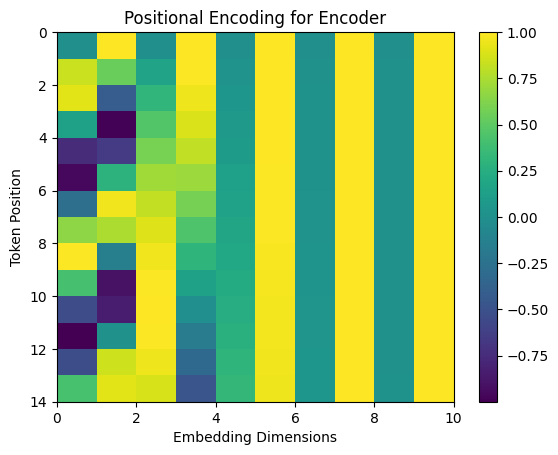

In [37]:

plt.title('Positional Encoding for Encoder')
plt.pcolormesh(pos_encoder[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, n_dim))
plt.ylim((ENCODER_SEQUENCE_LENGTH,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()


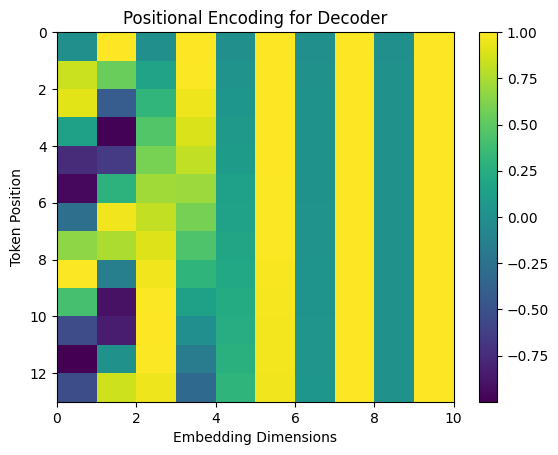

In [38]:
plt.title('Positional Encoding for Decoder')
plt.pcolormesh(pos_encoder[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.xlim((0, n_dim))
plt.ylim((DECODER_SEQUENCE_LENGTH,0))
plt.ylabel('Token Position')
plt.colorbar()
plt.show()

### Calculate Attention Manually

#### **Calculate Attention on Decoder**

Get some training examples

Shift decoder word index to right , because in decoder we will perform next word prediction

In [39]:
y_train.shape

torch.Size([291, 14])

Each Training Sample Should Have Size `[B,T]`

In [40]:
B=1
T = 13
decoder_idx = y_train[1][:-1]
decoder_idx= decoder_idx.reshape(shape=(B,T))
decoder_idx.shape

torch.Size([1, 13])

In [41]:
decoder_target_idx = y_train[1][1:]
decoder_target_idx = decoder_target_idx.reshape(shape=(B,T))

In [42]:
for x,y in zip(decoder_idx,decoder_target_idx) :
  print(f'{x.view(-1)}---predicts -->{y.view(-1)}')

tensor([285, 930, 176, 601, 680, 211, 476, 601, 563,  78, 934, 426, 165])---predicts -->tensor([930, 176, 601, 680, 211, 476, 601, 563,  78, 934, 426, 165,   0])


Get vector representation from each word + add positional embedding

In [43]:
vector_input_decoder  = decoder_embedding(decoder_idx) + pos_decoder

In [44]:
vector_input_decoder.shape

torch.Size([1, 13, 10])

Extract information such as Batch Size (B) , Token / Sequence Length (T) , and Channel (Embedding Dimension)

In [45]:
B,T,C = vector_input_decoder.shape

To calculate self attention we need have three matrices
- `Q` or Query Matrices
- `K` or Key Matrices
- `V` or Value Matrices

All above were produced by multiplying `vector_input` with distinct 3 distinct weight to produce the similar shape as `vector_input` `[B,T,C]`

In [46]:
linear_q_decoder = nn.Linear(in_features=C,out_features=C,dtype=float,bias=False)
linear_k_decoder = nn.Linear(in_features=C,out_features=C,dtype=float,bias=False)
linear_v_decoder  = nn.Linear(in_features=C,out_features=C,dtype=float,bias=False)

# yield q,k,v matrices
Q = linear_q_decoder(vector_input_decoder)
K = linear_k_decoder(vector_input_decoder)
V = linear_v_decoder(vector_input_decoder)



Next, we are going to calculate attention weight , or simply finding weight for performing weighted average vector for each word in the same sequences

to find the score we simply perform dot product beteen `q matrices` and `k matrices` the idea is that maximizing dot product ~ maximizing similarity

However we need to be careful about dimension
Q has dimension of `[B,T,C]` so with K does, we need to change K into size of
`[B,C,T]`

In [47]:
attention_weight = Q @ K.transpose(-2,-1)
attention_weight.shape

torch.Size([1, 13, 13])

by transpose, we switch the 2nd last dimension (C) with last dimension (T) , the output should have size of `[B,T,T]`

Since in transformer paper the attention score is yielded from scaled dot product

$$\begin{align*}
Attention(Q,K,V) = softmax(\cfrac{Q K^{T}}{\sqrt{d_{model}}})V
\end{align*}$$

In [48]:
attention_weight = attention_weight*C**-0.5

##### Performing Masking

**Masking Future Token**

In Decoder Section we perform next word prediction, by default attention calculate attention to all words, this will **leak** the information for future words, hence in decoder we need to mask future words

create masking matrix, containing, 1 if not future word otherwise 0 , we fill location with 0 --> with `-infinity` so that score would be 0

The masking matrix should be `square matrix` with size `[T,T]`

In [49]:
future_token_mask = torch.tril(torch.ones(T, T)).type(torch.LongTensor)

**Masking `<PAD>`  Token**

Another mask we should create is mask token , this is due to `<PAD>` token was only to fill remaining sequence so that each sequence have similar sequence length , however in terms of meaning there are no meaning on `<PAD>` token, hence we need to mask

In [50]:
# find index for padding mask
PADDING_IDX = word_to_idx_tgt['<PAD>']

# find
padding_mask = (decoder_target_idx != PADDING_IDX).unsqueeze(1).type(torch.LongTensor)
padding_mask

tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]])

In [51]:
attention_mask = future_token_mask & padding_mask
attention_mask

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]])

Final Resulting Shape should have size `[B,1,T,T]`

In [52]:
attention_masked = attention_weight.masked_fill(attention_mask==0,float('-inf'))
attention_masked

tensor([[[-0.0430,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.0561,  0.3117,    -inf,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.0234,  0.4045,  0.1367,    -inf,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.2575,  0.3178,  0.4394,  0.0595,    -inf,    -inf,    -inf,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.2279,  0.7820,  0.8945,  1.1305,  0.3796,    -inf,    -inf,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.1934,  0.4636,  0.1049, -0.3908,  0.1523,  0.8059,    -inf,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.0275,  0.0648, -0.1092, -0.0759,  0.7253,  0.1210, -0.2621,
             -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.3248,  0.4966,  0.439

In [53]:
attention_score = F.softmax(attention_masked,dim=-1)
attention_score

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4364, 0.5636, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2790, 0.4085, 0.3125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2450, 0.2602, 0.2939, 0.2010, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1202, 0.2092, 0.2342, 0.2965, 0.1399, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1518, 0.1989, 0.1389, 0.0846, 0.1457, 0.2801, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1243, 0.1363, 0.1145, 0.1184, 0.2639, 0.1442, 0.0983, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1336, 0.1587, 0.1499, 0.0760, 0.1633, 0.1637, 0.0807, 0.0741,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],


In [54]:
attention_score.shape

torch.Size([1, 13, 13])

In [55]:
np_masked = attention_score.reshape(shape=(T,T)).detach().numpy()
masked_df = pd.DataFrame(np_masked)
word_ticks_decoder = [idx_to_word_tgt[idx] for idx in decoder_idx.view(-1).detach().numpy()]
masked_df.index =word_ticks_decoder
masked_df.columns = word_ticks_decoder
masked_df

,<SOS>,jika,ada,orang,yang,dapat,memperbaikinya,orang,itu,adalah,tom,<EOS>,<PAD>
<SOS>,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
jika,0.436450,0.563550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
ada,0.279029,0.408462,0.312509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
orang,0.244970,0.260202,0.293859,0.200970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
yang,0.120218,0.209228,0.234160,0.296470,0.139924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
dapat,0.151798,0.198891,0.138937,0.084636,0.145675,0.280064,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
memperbaikinya,0.124305,0.136317,0.114548,0.118427,0.263888,0.144207,0.098308,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
orang,0.133619,0.158659,0.149862,0.076018,0.163332,0.163686,0.080746,0.074078,0.000000,0.000000,0.000000,0.0,0.000000
itu,0.088220,0.116740,0.118335,0.140791,0.056910,0.099344,0.138524,0.162195,0.078941,0.000000,0.000000,0.0,0.000000
adalah,0.060542,0.075053,0.074247,0.167249,0.078193,0.039763,0.074255,0.172157,0.185582,0.072959,0.000000,0.0,0.000000


##### Visualize Attention Score (Decoder) in Matplotlib

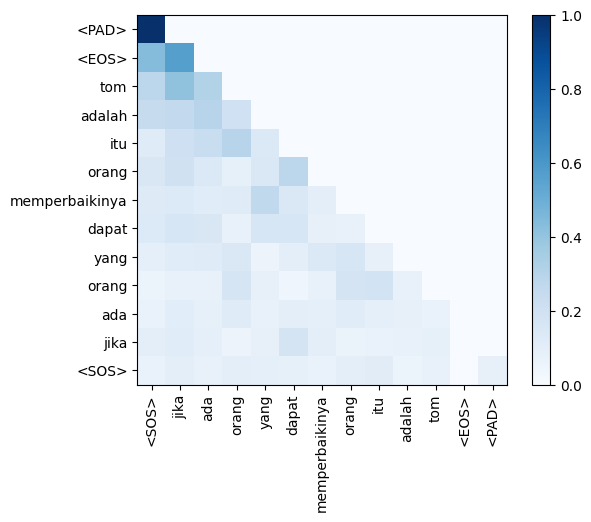

In [56]:
plt.imshow(np_masked,cmap='Blues')
plt.xticks([x for x in range(len(word_ticks_decoder))] , word_ticks_decoder,rotation='vertical')
plt.yticks([x for x in range(len(word_ticks_decoder))] , word_ticks_decoder[::-1])
plt.colorbar()

Multiply Score with `V` matrices

In [57]:
dropout = nn.Dropout(0.3)

In [58]:
out = attention_score @ V
out==0

tensor([[[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, Fals

In [59]:
out_dropout = dropout(attention_score) @ V
out_dropout==0

tensor([[[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, Fals

After creating attention , we proceed with last operation for attention, by projecting the attention output, what does it mean by projection ? We multiply the attention (output) vector with MultiLayer Perceptron

In [60]:
attention_project = nn.Linear(in_features=C,out_features=C,dtype=float)

attention_projected = attention_project(out)
attention_projected

tensor([[[-0.1973, -0.4083,  0.0274, -0.3198, -0.1798,  0.1220,  0.1258,
          -0.3597, -0.1956, -0.3162],
         [-0.1499, -0.1407,  0.2896, -0.2185, -0.2604, -0.0777, -0.1264,
          -0.2256, -0.3647, -0.2791],
         [-0.2432, -0.1673,  0.2677, -0.2508, -0.2162, -0.0177, -0.0673,
          -0.2597, -0.5166, -0.3150],
         [-0.3804, -0.2210,  0.1170, -0.1654, -0.1097, -0.1187,  0.0786,
          -0.2009, -0.4536, -0.2011],
         [-0.4744, -0.2155, -0.0737,  0.0177, -0.0309, -0.2702,  0.1222,
          -0.1640, -0.2964, -0.1250],
         [-0.3491, -0.1821,  0.0322, -0.0183, -0.1030, -0.2471, -0.0479,
          -0.2144, -0.0922, -0.2390],
         [-0.3734, -0.2428, -0.1214,  0.0806, -0.0809, -0.2676,  0.0247,
          -0.1725, -0.0163, -0.1893],
         [-0.3825, -0.2516, -0.0090, -0.0150, -0.0691, -0.2291,  0.0420,
          -0.1668, -0.0957, -0.1944],
         [-0.4426, -0.3088,  0.0727, -0.0609, -0.0049, -0.2373,  0.1627,
          -0.0543, -0.1466, -0.0933],
 

In [61]:
attention_projected.shape

torch.Size([1, 13, 10])

#### **Multi Head Attention**

Usually the relation between number of dimension and n heads can be like this
for example if we want to have 2 heads , then each heads dimension is = n_dim / n_heads

in our case `n_dim_heads = 10 //2 = 5`

In [62]:
n_heads = 2
n_dim_heads = 5
batch_size = 1

In [63]:
vector_input_decoder.shape

torch.Size([1, 13, 10])

In [64]:
linear_q_decoder_multihead_1 = nn.Linear(C, n_dim_heads, bias=False,dtype=float)
linear_k_decoder_multihead_1 = nn.Linear(C, n_dim_heads, bias=False,dtype=float)
linear_v_decoder_multihead_1 = nn.Linear(C, n_dim_heads, bias=False,dtype=float)


linear_q_decoder_multihead_2 = nn.Linear(C, n_dim_heads, bias=False,dtype=float)
linear_k_decoder_multihead_2 = nn.Linear(C, n_dim_heads, bias=False,dtype=float)
linear_v_decoder_multihead_2 = nn.Linear(C, n_dim_heads, bias=False,dtype=float)



In [65]:
Q_1 = linear_q_decoder_multihead_1(vector_input_decoder)
K_1 = linear_k_decoder_multihead_1(vector_input_decoder)
V_1 = linear_v_decoder_multihead_1(vector_input_decoder)

Q_2 = linear_q_decoder_multihead_2(vector_input_decoder)
K_2 = linear_k_decoder_multihead_2(vector_input_decoder)
V_2 = linear_v_decoder_multihead_2(vector_input_decoder)

Calculate Attention on both heads

In [66]:
attention_score_1 = Q_1 @ K_1.transpose(-2,-1)
attention_score_2 = Q_1 @ K_1.transpose(-2,-1)

# masking
attention_score_1 = attention_score_1.masked_fill(attention_mask==0,float('-inf'))
attention_score_2 = attention_score_2.masked_fill(attention_mask==0,float('-inf'))

attention_score_1 = F.softmax(attention_score_1,dim=-1)
attention_score_2 = F.softmax(attention_score_2,dim=-1)

In [67]:
attention_score_2

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6209, 0.3791, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6734, 0.1591, 0.1676, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3054, 0.1563, 0.1750, 0.3633, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0791, 0.0473, 0.0219, 0.3555, 0.4961, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0510, 0.0865, 0.0528, 0.4818, 0.1290, 0.1990, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1016, 0.2065, 0.2112, 0.0919, 0.0559, 0.1820, 0.1509, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0938, 0.1242, 0.0852, 0.1654, 0.1492, 0.1343, 0.1111, 0.1368,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000],


In [68]:
# multiply by value matrices
out_h1 = attention_score_1 @ V_1
out_h2 = attention_score_2 @ V_2

In [69]:
out_h1.shape

torch.Size([1, 13, 5])

In [70]:
out_h2.shape

torch.Size([1, 13, 5])

To make the size is the same again as our input, we could concat both
based on our last dimension (-1) `C`

In [71]:
out_concat = torch.cat([out_h1,out_h2], dim=-1)
out_concat.shape

torch.Size([1, 13, 10])

In [72]:
attention_project(out_concat)

tensor([[[-0.4616, -0.3101,  0.0903,  0.1469,  0.0410, -0.2930,  0.1543,
           0.1421, -0.1048, -0.0280],
         [-0.4039, -0.2956, -0.3209,  0.2663, -0.0363, -0.1955,  0.2313,
           0.0952, -0.1623, -0.1803],
         [-0.3432, -0.2879, -0.1933,  0.3075, -0.1155, -0.2193,  0.1528,
           0.1858, -0.1162, -0.1005],
         [-0.1892, -0.1281, -0.0909,  0.3888, -0.3482, -0.1351,  0.1272,
           0.2775, -0.3356,  0.0425],
         [-0.0742, -0.2212,  0.8069, -0.0271, -0.2950,  0.2445,  0.1969,
           0.3876, -0.6162,  0.1334],
         [-0.1947, -0.0958,  0.2045,  0.1938, -0.3400,  0.0279,  0.2600,
           0.3189, -0.5683,  0.1363],
         [-0.3145, -0.1855, -0.2030,  0.2807, -0.2496, -0.0959,  0.2931,
           0.2515, -0.3951,  0.0038],
         [-0.2590, -0.1497,  0.1480,  0.2118, -0.2929, -0.0207,  0.2414,
           0.3213, -0.5119,  0.1032],
         [-0.1167, -0.2565,  0.1931,  0.2430, -0.3067,  0.0630,  0.0854,
           0.2656, -0.3693, -0.0530],
 

For making calculating attention easier, we can create OOP based

As the model capacity is getting increased, there is a chance that the model will overfit, to tackle those problem we can use `Dropout` Mechanism.

So where to apply dropout in Attention Head, we apply dropout after calculating attention



#### Attention Class

In [73]:

class AttentionHead(nn.Module):
    def __init__(self, n_dim,n_dim_head,dropout_p):
        super().__init__()
        self.linear_key = nn.Linear(n_dim, n_dim_head, bias=False)
        self.linear_query = nn.Linear(n_dim, n_dim_head, bias=False)
        self.linear_value = nn.Linear(n_dim, n_dim_head, bias=False)
        self.attention_dropout = nn.Dropout(dropout_p)
        self.double()
    def forward(self, q_vec,k_vec,v_vec,mask=None):
        B,T,C = q_vec.shape
        Q = self.linear_query(q_vec) # (B,T,C)
        K = self.linear_key(k_vec)   # (B,T,C)
        # compute attention scores ("affinities")
        attention_weight = Q @ K.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)

        # perform masking
        if mask is not None :
          attention_weight = attention_weight.masked_fill(mask==0,float('-inf')) # (B, T, T)

        attention_score = F.softmax(attention_weight, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        V = self.linear_value(v_vec) # (B,T,C)
        out = self.attention_dropout(attention_score) @ V # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

Let's try to perform attention on single head

In [74]:
attention = AttentionHead(n_dim=C,n_dim_head = C//1,dropout_p=0.1)

In [75]:
attention.forward(q_vec = vector_input_decoder,
                  k_vec = vector_input_decoder,
                  v_vec = vector_input_decoder,mask=attention_mask)

tensor([[[-0.1268, -0.1985,  0.2463,  0.5713, -0.3246,  0.4527, -0.1515,
           0.4478, -0.3808, -0.0722],
         [-0.0531, -0.0750,  0.0957,  0.3741, -0.4766,  0.6913, -0.2580,
           0.2124, -0.2529, -0.1095],
         [-0.1315,  0.0491, -0.2209,  0.4367, -0.4486,  0.7117, -0.4722,
          -0.0417, -0.1377,  0.0483],
         [-0.2099,  0.0240, -0.0804,  0.3299, -0.6127,  0.9035, -0.5675,
          -0.2694,  0.2418, -0.2821],
         [-0.1498,  0.3923, -0.0236, -0.0078, -0.7455,  1.1271, -0.6937,
          -0.4305,  0.4928, -0.3010],
         [-0.1020,  0.9664,  0.4020, -0.3307, -0.5995,  0.9551, -0.6605,
          -0.1535,  0.5691, -0.0832],
         [-0.2126, -0.2640,  0.0877,  0.2095, -0.2936,  0.3319, -0.2609,
          -0.1233,  0.0477, -0.1177],
         [-0.2191,  0.1318,  0.3726, -0.0478, -0.5084,  0.7139, -0.5489,
          -0.3466,  0.5004, -0.3265],
         [-0.1147,  0.3476,  0.1924, -0.2022, -0.4712,  0.7298, -0.4476,
          -0.3052,  0.4682, -0.2085],
 

#### MultiHead Attention Class

In Multihead Attention we calculate attention separately in differents heads, the dimension in each heads is `n_dim//n_heads` , after that we concate the vector from each heads.

More information, in multihead attention we should add dropout after projection

In [76]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_dim,num_heads,dropout_p):
        super().__init__()
        self.num_heads = num_heads
        n_dim_head = n_dim // num_heads
        # stack multiple  heads
        self.heads = nn.ModuleList([AttentionHead(n_dim,n_dim_head,dropout_p) for _ in range(num_heads) ])
        self.projection_dropout = nn.Dropout(dropout_p)

        self.proj = nn.Linear(n_dim, n_dim)
        self.double()

    def forward(self, q_vec,k_vec,v_vec,mask=None):
        out = torch.cat([head(q_vec=q_vec,k_vec=k_vec,v_vec = v_vec, mask=mask) for head in self.heads], dim=-1)
        out = self.projection_dropout (self.proj(out))
        return out

In [77]:
config = {
    'n_dim' : 10,
    'num_heads' : 2,
    "dropout_p":0.1
}
multihead_attention = MultiHeadAttention(**config)

In [78]:
multihead_attention

MultiHeadAttention(
  (heads): ModuleList(
    (0-1): 2 x AttentionHead(
      (linear_key): Linear(in_features=10, out_features=5, bias=False)
      (linear_query): Linear(in_features=10, out_features=5, bias=False)
      (linear_value): Linear(in_features=10, out_features=5, bias=False)
      (attention_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (projection_dropout): Dropout(p=0.1, inplace=False)
  (proj): Linear(in_features=10, out_features=10, bias=True)
)

Now, after we finished constructing how to calculate attention , we can create bigger blocks :

- **Encoder**
- **Decoder**

### Encoder Blocks

Remember that our encoder has structure like this
<img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm.png">

<center><a href="https://jalammar.github.io/images/t/transformer_resideual_layer_norm.png">Source : Jay Alammar</a></center>

So recall again inside each encoder block, we have
1. **Self Attention** --> Followed by Residual Connection --> Layer Norm
2. **Feed Forward** --> Followed by Residual Connection --> Layer Norm

The Feed Forward have structure like this :    
[feed forward.png]

In each sublayer we should place the dropout , remember the dropout works to prevent model from overfitting

In Encoder block, the dropout placed after feedforward

In [79]:
class EncoderBlock(nn.Module) :
    def __init__(self,n_dim,num_heads,dropout_p) :
      super().__init__()
      # add multihead attention
      self.multihead_attention = MultiHeadAttention(n_dim=n_dim,num_heads=num_heads,dropout_p=dropout_p)
      # 1st layer norm after multihead attention
      self.ln_1 = nn.LayerNorm(n_dim)
      # add feed forward
      # in transformer paper --> the first multilayer perceptrion make the dimension 4*n_dim
      self.feed_forward = nn.Sequential(
          nn.Linear(n_dim,4*n_dim),
          nn.ReLU(),
          nn.Dropout(dropout_p),
          nn.Linear(4*n_dim,n_dim),


      )
      # 2nd layer norm after feed forward
      self.ln_2 = nn.LayerNorm(n_dim)

      self.double()








Then we add `forward` method to calculate operation in decoder block

1. calculate self attention
2. continue with residual connection
3. perform layer normalization (1)
4. enter feed-forward
5. continue with residual connection
6. perform layer norm again

In [80]:
class EncoderBlock(nn.Module) :
    def __init__(self,n_dim,num_heads,dropout_p) :
      super().__init__()
      # add multihead attention
      self.multihead_attention = MultiHeadAttention(n_dim=n_dim,num_heads=num_heads,dropout_p=dropout_p)
      # 1st layer norm after multihead attention
      self.ln_1 = nn.LayerNorm(n_dim)
      # add feed forward
      # in transformer paper --> the first multilayer perceptrion make the dimension 4*n_dim

      self.feed_forward = nn.Sequential(
          nn.Linear(n_dim,4*n_dim),
          nn.ReLU(),
          nn.Dropout(dropout_p),
          nn.Linear(4*n_dim,n_dim)

      )
      # 2nd layer norm after feed forward
      self.ln_2 = nn.LayerNorm(n_dim)


      self.double()
    def forward(self,x,mask=None) :
      # perform multihead attention

      x = x + self.multihead_attention(q_vec=x,k_vec=x,v_vec=x,mask=mask) # to perform residual connection we only add original input x and operation from multihead attention
      # perform layer norm
      x = self.ln_1(x)

      # enter feed forward
      x = x + self.feed_forward(x)
      # enter layer norm again
      x = self.ln_2(x)

      return x


Let's verify whether our encoder block working properly

We see that the encoder block can be stacked one to another

<img src="https://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png">

We can proceed to create encoder part from our architecture, yeay! we are halfway through it

So recall again to what happens in Encoder Sections

$1^{st}$**Our Input** : Sequence of word represented as index , having size of `[B,T]`




$2^{st}$ **Embedding Layer** : Retrieve each word Embedding + Positional Encoding  --> we need to create the embedding


We will create word embedding first to our source language vocabulary

#### Encoder Class

In [81]:
class Encoder(nn.Module) :
  def __init__(self,src_vocab_num,
               n_dim, num_heads,dropout_p,
               n_block,sequence_length,device) :
      super().__init__()
      # create word embedding
      self.device = device
      self.src_word_embedding = nn.Embedding(src_vocab_num,
                                            n_dim)

      # create positional encoding
      self.positional_encoding = positional_encoding(position=sequence_length,n_dim=n_dim,device=device)
      self.positional_encoding.to(device)

      # encoder blocks
      self.encoder = nn.ModuleList([EncoderBlock(n_dim,num_heads,dropout_p) for _ in range(n_block)])

      # embedding dropout
      self.embed_dropout = nn.Dropout(dropout_p)

      self.double()

  def forward(self,x,mask=None) :
    # x is our input should have size --> [B,T]
    B,T = x.shape
    pos = torch.arange(0, T, dtype=torch.long, device=self.device)
    vec = self.embed_dropout(self.src_word_embedding(x) + self.positional_encoding[:,pos,:])
    vec = vec.to(self.device)



    for enc in self.encoder :
      vec = enc(vec,mask=mask)

    return vec


#### Testing Encoder Block

Now, lets validate it, by using single batch training sample

In [82]:
sample_x = X_train[0].unsqueeze(-2)
sample_x.shape

torch.Size([1, 14])

make object of encoder

In [83]:
config

{'n_dim': 10, 'num_heads': 2, 'dropout_p': 0.1}

In [84]:
config = {"src_vocab_num":len(eng_vocab),
          "n_dim":10,
          "num_heads":2,
          "n_block":1,
          "dropout_p":0.1,
          "device" : 'cuda' if torch.cuda.is_available()==True else 'cpu' ,
          "sequence_length":ENCODER_SEQUENCE_LENGTH}

encoder = Encoder(**config)
encoder

Encoder(
  (src_word_embedding): Embedding(935, 10)
  (encoder): ModuleList(
    (0): EncoderBlock(
      (multihead_attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (linear_key): Linear(in_features=10, out_features=5, bias=False)
            (linear_query): Linear(in_features=10, out_features=5, bias=False)
            (linear_value): Linear(in_features=10, out_features=5, bias=False)
            (attention_dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (projection_dropout): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=10, out_features=10, bias=True)
      )
      (ln_1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=10, out_features=40, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=40, out_features=10, bias=True)
      )
      (ln_2): LayerNorm((10,), 

The output should have size `[B,T,C]`

### Decoder Blocks

[Picture of Decoder.png]

Each Encoder Block consists of
1. Multihead (Masked Self) Attention
2. Intra Attention
3. Feed Forward Layer

[Explain] Multihead Self Attention

[Explain] Encoder-Decoder Attention

we want to extract the vector from encoder hence
- our query_vector = vector from self attention (decoder)
- our key_vector = vector from encoder block
- our value_vector = vector from encoder block

Dropout in each Decoder Block, previously we add dropout in attention mechanism, in each Decoder Block we also add dropout after feed forward before entering other process such as entering another block

In [85]:
class DecoderBlock(nn.Module) :
    def __init__(self,n_dim,num_heads,dropout_p) :
      super().__init__()
      # add multihead(masked self attention) attention
      self.multihead_attention = MultiHeadAttention(n_dim,num_heads,dropout_p)
      # 1st layer norm after multihead attention
      self.ln_1 = nn.LayerNorm(n_dim)

      # adding intra attention layer
      self.intra_attention = MultiHeadAttention(n_dim,num_heads,dropout_p)
      # 2nd layer norm after intra attention layer
      self.ln_2 = nn.LayerNorm(n_dim)

      # add feed forward
      # in transformer paper --> the first multilayer perceptrion make the dimension 4*n_dim

      self.feed_forward = nn.Sequential(
          nn.Linear(n_dim,4*n_dim),
          nn.ReLU(),
          nn.Linear(4*n_dim,n_dim),
          nn.Dropout(dropout_p)
      )

      self.ln_3 = nn.LayerNorm(n_dim)

      self.double()
    def forward(self,encoder_output,decoder_input,mask=None) :
      # perform multihead attention
      decoder_vector = decoder_input + self.multihead_attention(q_vec=decoder_input,k_vec=decoder_input,v_vec = decoder_input , mask=mask)
      # perform layer norm
      decoder_vector = self.ln_1(decoder_vector)
      # perform intra attention , in decoder section we do not perform masking
      decoder_vector = decoder_vector + self.intra_attention(q_vec=decoder_vector ,
                                                             k_vec=encoder_output ,
                                                             v_vec=encoder_output,mask=None)
      # perform second layer norm
      decoder_vector = self.ln_2(decoder_vector)

      # feed to feed forward layer + residual connection
      decoder_vector = decoder_vector + self.feed_forward(decoder_vector)
      decoder_vector = self.ln_3(decoder_vector)

      return decoder_vector



#### Decoder Class

In [86]:
class Decoder(nn.Module) :
  def __init__(self,tgt_vocab_num,
               n_dim, num_heads,dropout_p,
               n_block,sequence_length,device) :
      super().__init__()
      self.device = device
      # create word embedding
      self.tgt_word_embedding = nn.Embedding(tgt_vocab_num,
                                            n_dim)

      # create positional encoding
      self.positional_encoding = positional_encoding(position=sequence_length,n_dim=n_dim,device=device)
      self.positional_encoding.to(device)
      # encoder blocks
      self.decoder = nn.ModuleList([DecoderBlock(n_dim,num_heads,dropout_p) for _ in range(n_block)])

      # last projection layer --> linear layer
      self.project = nn.Linear(n_dim,tgt_vocab_num)

      # embedding dropout
      self.embed_dropout = nn.Dropout(dropout_p)
      self.double()

  def forward(self,y,encoder_output,mask=None) :
    # y is our input should have size --> [B,T]
    B,T = y.shape
    pos = torch.arange(0, T, dtype=torch.long, device=self.device)
    vec = self.embed_dropout(self.tgt_word_embedding(y) + self.positional_encoding[:,pos,:])
    vec = vec.to(self.device)

    for dec in self.decoder :
      vec = dec(encoder_output = encoder_output,decoder_input=vec,mask=mask)

    return vec


Making Transformer Class

### Transformer Class

Also we should notice that we apply different masking

1. In Encoder section we perform mask for `padding`
2. In Decoder section we perform `future words` mask and `padding` mask

Hence, we can create builtin masking function in our `Transformer` Class

In [87]:
class Transformer(nn.Module) :
    def __init__(self,tgt_vocab_num,
                 src_vocab_num,n_dim,
                 num_heads,n_encoder,n_decoder,
                 dropout_p,
                 sequence_length_encoder,
                 sequence_length_decoder,
                 src_padding_idx,
                 tgt_padding_idx,
                 device
                 ) :
        super().__init__()
        self.device = device
        self.src_padding_idx = src_padding_idx
        self.tgt_padding_idx = tgt_padding_idx

        self.encoder = Encoder(src_vocab_num=src_vocab_num,
                               n_dim=n_dim,num_heads=num_heads,dropout_p=dropout_p,
                               n_block=n_encoder,
                               sequence_length=sequence_length_encoder,device=device)
        self.decoder = Decoder(tgt_vocab_num=tgt_vocab_num,
                        n_dim=n_dim,num_heads=num_heads,dropout_p=dropout_p,
                        n_block=n_decoder,
                        sequence_length=sequence_length_decoder,device=device)
        self.final_projection = nn.Linear(n_dim,tgt_vocab_num)

        self.double()
    def make_encoder_mask(self, X):

        #X = [B,T]

        padding_mask = (X != self.src_padding_idx).unsqueeze(1).type(torch.LongTensor)
        padding_mask = padding_mask.to(self.device)

        #padding_mask = [B, 1, 1, T]

        return padding_mask

    def make_decoder_mask(self, y):

        #y = = [B,T]
        B,T = y.shape

        padding_mask = (y != self.tgt_padding_idx).unsqueeze(1).type(torch.LongTensor)
        padding_mask = padding_mask.to(self.device)
        #padding_mask = [B, 1, 1, T]

        # future word mask
        future_mask = torch.tril(torch.ones((T, T))).bool()
        future_mask = future_mask.to(self.device)
        #trg_sub_mask = [trg len, trg len]

        mask = future_mask & padding_mask
        mask = mask.to(self.device)
        #mask = [B 1, T, T]

        return mask


    def forward(self,X,y) :
       encoder_mask = self.make_encoder_mask(X)
       decoder_mask = self.make_decoder_mask(y)

       encoder_out = self.encoder(X,mask=encoder_mask)

       decoder_out = self.decoder(y=y,encoder_output=encoder_out,mask=decoder_mask)

       # project ith linear
       logit = self.final_projection(decoder_out)

       return logit






don't forget since we have nonlinearity with `ReLU` activation we should intialize carefully

In [88]:
def _init_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
    elif isinstance(module, nn.LayerNorm):
        torch.nn.init.zeros_(module.bias)
        torch.nn.init.ones_(module.weight)

Let's perform one way prediction

In [89]:
X_sample = X_train[0].unsqueeze(-2)
# y is shifted to right
y_sample = y_train[0][:-1].unsqueeze(-2)

In [90]:
X_sample

tensor([[  0, 796, 925,  56, 890,  83, 903, 626, 692,   0, 183, 183, 183,   0]])

In [91]:
X_sample.shape

torch.Size([1, 14])

In [92]:
B,T = y_sample.shape

In [93]:
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":10, "num_heads" : 2,
          "dropout_p":0.1,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "n_encoder":1, "n_decoder":1,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model = Transformer(**config)
model.apply(_init_weights)

Transformer(
  (encoder): Encoder(
    (src_word_embedding): Embedding(935, 10)
    (encoder): ModuleList(
      (0): EncoderBlock(
        (multihead_attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-1): 2 x AttentionHead(
              (linear_key): Linear(in_features=10, out_features=5, bias=False)
              (linear_query): Linear(in_features=10, out_features=5, bias=False)
              (linear_value): Linear(in_features=10, out_features=5, bias=False)
              (attention_dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (projection_dropout): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=10, out_features=10, bias=True)
        )
        (ln_1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=10, out_features=40, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=40,

#### Test It

If the result were correct,it should return vector with dimentsion :     

`[B,T,NUM_VOCAB_IN_TARGET,]`

In [94]:
X_sample,y_sample = get_batches(split='train',batch_size=1)
y_input = y_sample[:,:-1]
y_label = y_sample[:,1:]

In [95]:
X_sample

tensor([[  0, 249, 441, 918, 498, 803, 283,  94,   0, 183, 183, 183, 183,   0]])

In [96]:
y_sample

tensor([[285, 519, 516, 343, 942, 544, 519, 132, 343, 942, 743, 426, 165,   0]])

In [97]:
y_input

tensor([[285, 519, 516, 343, 942, 544, 519, 132, 343, 942, 743, 426, 165]])

In [98]:
y_label

tensor([[519, 516, 343, 942, 544, 519, 132, 343, 942, 743, 426, 165,   0]])

In [99]:
logit = model(X_sample,y_input)
logit

tensor([[[-0.0043, -0.0051,  0.0013,  ...,  0.0033,  0.0024,  0.0022],
         [-0.0049, -0.0113,  0.0104,  ...,  0.0007,  0.0034,  0.0020],
         [-0.0046, -0.0048,  0.0081,  ..., -0.0038,  0.0003, -0.0001],
         ...,
         [-0.0020,  0.0037,  0.0125,  ...,  0.0010, -0.0028, -0.0072],
         [-0.0037,  0.0070,  0.0073,  ...,  0.0018, -0.0035, -0.0070],
         [-0.0095,  0.0064,  0.0024,  ...,  0.0004, -0.0032, -0.0047]]],
       dtype=torch.float64, grad_fn=<ViewBackward0>)

In [100]:
logit.shape

torch.Size([1, 13, 976])

What if we want to return the probability of the next word, don't worry we can process the logit to the softmax which dimension we should calculate

What we want in each `T` there is probability of all vocabulary, hence we choose 2nd last dimension (T)

In [101]:
proba = F.softmax(logit,dim=-2)

Let's say we want to extract first word from 13 sequence

`[B,T,VOCAB]`

In [102]:
first_sequence_proba = proba[:,0,:]

We want to find which word is most probable

In [103]:
first_sequence_proba.argmax()

tensor(145)

In [104]:
first_sequence_proba[:,399]

tensor([0.0765], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [105]:
idx_to_word_tgt[399]

'perekonomian'

In [106]:
y_train

tensor([[285, 873, 417,  ..., 426, 165,   0],
        [285, 930, 176,  ..., 426, 165,   0],
        [285, 605, 785,  ..., 426, 165,   0],
        ...,
        [285, 934, 262,  ..., 426, 165,   0],
        [285, 110, 126,  ..., 165, 165,   0],
        [285, 127, 143,  ..., 165, 165,   0]])

In [107]:
idx_to_word_tgt[911]

'kantor'

#### Calculating Loss

We calculate loss function on logit not the probability version

to calulate loss `F.cross_entropy` takes :    
1. `input` --> logit --> shape `[T,N_VOCAB]`
2. `target` -->y_label--> shape `[T]`

since then we need to reshape it first

In [112]:
loss = F.cross_entropy(logit.reshape((13,976)), y_label.reshape((13)))

In [113]:
logit.shape

torch.Size([1, 13, 976])

In [114]:
y_label.shape

torch.Size([1, 13])

In [115]:
loss.item()

6.880715694039195

In [116]:
X_minibatch,y_minibatch = get_batches(split='train',batch_size=32)
y_input_minibatch = y_minibatch[:,:-1]
y_label_minibatch = y_minibatch[:,1:]

# Forward pass
logit = model(X_minibatch,y_input_minibatch)
logit

tensor([[[-7.4005e-03, -1.0210e-02,  1.4930e-03,  ...,  3.3960e-03,
           4.7314e-03,  9.2179e-04],
         [-7.2051e-03, -1.1055e-02,  6.6418e-03,  ...,  5.9977e-04,
           3.6686e-03,  3.0306e-03],
         [-9.9776e-03, -3.7150e-03,  1.0212e-02,  ...,  7.0561e-04,
           6.0887e-04, -2.2644e-03],
         ...,
         [-6.2179e-03,  1.2959e-03,  1.3546e-02,  ..., -5.7424e-04,
          -1.4835e-03, -7.7186e-03],
         [-3.6598e-03,  7.0557e-03,  7.2678e-03,  ...,  1.7936e-03,
          -3.5185e-03, -6.9767e-03],
         [-1.1557e-02,  6.1952e-03,  2.2967e-03,  ...,  1.6933e-04,
          -2.2088e-03, -6.3365e-03]],

        [[-4.2708e-03, -5.0645e-03,  1.2635e-03,  ...,  3.3504e-03,
           2.3910e-03,  2.1798e-03],
         [-6.9987e-03, -1.1114e-02,  6.6752e-03,  ...,  6.1942e-04,
           3.6144e-03,  3.2136e-03],
         [-3.1863e-03, -9.9411e-03,  1.3030e-02,  ...,  1.4501e-04,
           2.4482e-03,  1.3825e-04],
         ...,
         [-1.8915e-03,  3

In [117]:
logit.shape

torch.Size([32, 13, 976])

In [118]:
y_label_minibatch.shape

torch.Size([32, 13])

In [119]:
B,T,VOCAB = logit.shape

logit_ = logit.reshape(shape=(B*T,VOCAB))
y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))

Don't forget we need to stop calculating loss on padding idx


In [120]:
TGT_PAD_IDX = word_to_idx_tgt['<PAD>']
loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=TGT_PAD_IDX)
loss

tensor(6.8842, dtype=torch.float64, grad_fn=<NllLossBackward0>)

As Example we are going to create next word prediction model using

## BabySitting Learning Process


After having a deep dive about the arhitecture, now its time to create training pipeline


We want to evaluate how good the model prediction in other set, such as validation set, hence we create evaluate loss function

In [121]:
@torch.no_grad()
def evaluate_loss(split,model,device):
    # Get the data
    X, y = {
        'train': (X_train, y_train),
        'valid': (X_val, y_val),
        'test': (X_test, y_test)
    }[split]
    y_input = y[:,:-1]
    y_label = y[:,1:]
    X = X.to(device)
    y_input = y_input.to(device)
    y_label = y_label.to(device)

    logit = model(X,y_input)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_ = y_label.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_,ignore_index=TGT_PAD_IDX)

    return loss

#### Choosing What Part of Model to be bigger

<img src="../assets/transformers/raschka_improving_generalization.png">

To improve model generation the first recommended way is **Increase Training Data** .

However for now, we won't demonstrate the first one, because computationally quite longer to train (we play with toy scale dataset)

We will try Determine which setups from below

- Increase Embedding Dimension
- Increase Model Depth

##### Increasing Embedding Dimension

#parameters : 90872


/home/ubuntu/learning/natural-language-processing/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Step       0/   1000 | Loss 6.8827 | Loss on Validation 6.8695 | Step time 51.34 ms
Step     100/   1000 | Loss 5.5246 | Loss on Validation 5.8242 | Step time 16.29 ms
Step     200/   1000 | Loss 4.9659 | Loss on Validation 5.3720 | Step time 17.53 ms
Step     300/   1000 | Loss 4.5780 | Loss on Validation 5.1289 | Step time 20.27 ms
Step     400/   1000 | Loss 4.5484 | Loss on Validation 5.0841 | Step time 15.35 ms
Step     500/   1000 | Loss 4.4681 | Loss on Validation 5.0545 | Step time 18.85 ms
Step     600/   1000 | Loss 4.2301 | Loss on Validation 5.0659 | Step time 16.51 ms
Step     700/   1000 | Loss 4.0187 | Loss on Validation 5.1125 | Step time 14.34 ms
Step     800/   1000 | Loss 3.7816 | Loss on Validation 5.0754 | Step time 16.19 ms
Step     900/   1000 | Loss 3.7436 | Loss on Validation 5.1033 | Step time 17.47 ms


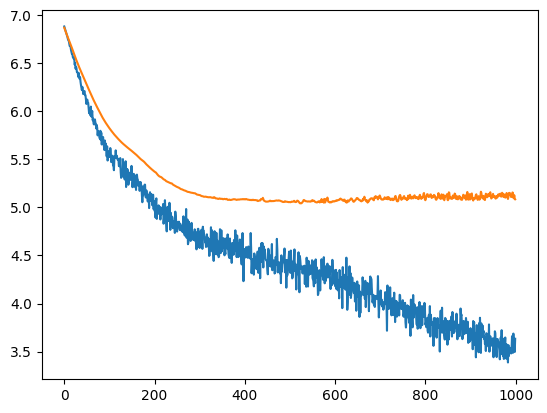

In [122]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":20, "num_heads" : 1,
          "n_encoder":1, "n_decoder":1,
          "dropout_p":0,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model_increase_embedding = Transformer(**config)
model_increase_embedding.apply(_init_weights)
# check model parameter
print('#parameters :', sum([p.numel() for p in model_increase_embedding.parameters()]))

for p in model_increase_embedding.parameters() :
  p.require_grad = True


optimizer = torch.optim.Adam(model_increase_embedding.parameters(),weight_decay=0.01)

losses = []
losses_val = []
max_iter = 1_000
for iter in range(max_iter):
    t1 = time.time()

    # Minibatch Samples
    X_minibatch,y_minibatch = get_batches(split='train',batch_size=BATCH_SIZE)
    y_input_minibatch = y_minibatch[:,:-1]
    y_label_minibatch = y_minibatch[:,1:]

    # Forward pass
    logit = model_increase_embedding(X_minibatch,y_input_minibatch)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=config['tgt_padding_idx'])

    # Backward pass
    for p in model_increase_embedding.parameters():
        p.grad = None

    loss.backward()

    optimizer.step()
    loss_val = evaluate_loss(split='valid',model=model_increase_embedding,device=config['device'])
    # Append the loss
    losses.append(loss.item())
    losses_val.append(loss_val.item())
    elapsed = time.time() - t1
    if iter % 100 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss {loss.item():.4f} "
              f"| Loss on Validation {loss_val.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")

# plot the loss
iter = [x for x in range(len(losses))]
plt.plot(iter,losses)
plt.plot(iter,losses_val)


##### Increase Depth
Encoder & Decoder 2x

#parameters : 46642
Step       0/   1000 | Loss 6.8837 | Loss on Validation 6.8766 | Step time 26.42 ms
Step     100/   1000 | Loss 6.0395 | Loss on Validation 6.1934 | Step time 20.86 ms
Step     200/   1000 | Loss 5.4961 | Loss on Validation 5.7063 | Step time 24.70 ms
Step     300/   1000 | Loss 5.3849 | Loss on Validation 5.5223 | Step time 22.31 ms
Step     400/   1000 | Loss 5.1008 | Loss on Validation 5.3052 | Step time 21.65 ms
Step     500/   1000 | Loss 4.7320 | Loss on Validation 5.1385 | Step time 21.34 ms
Step     600/   1000 | Loss 4.4580 | Loss on Validation 5.0823 | Step time 21.16 ms
Step     700/   1000 | Loss 4.4095 | Loss on Validation 5.0674 | Step time 23.68 ms
Step     800/   1000 | Loss 4.2044 | Loss on Validation 5.0552 | Step time 22.86 ms
Step     900/   1000 | Loss 4.3700 | Loss on Validation 5.0821 | Step time 21.45 ms


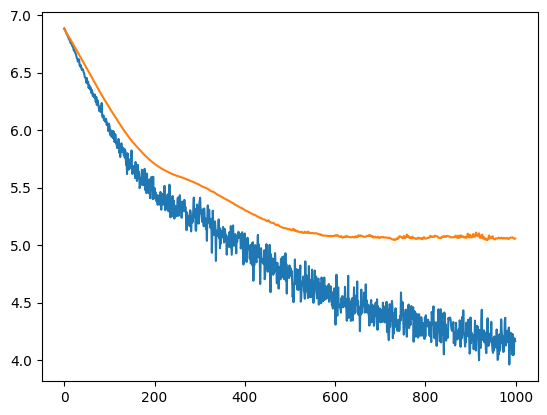

In [123]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":10, "num_heads" : 1,
          "n_encoder":2, "n_decoder":2,
          "dropout_p":0,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model_increase_depth = Transformer(**config)
model_increase_depth.apply(_init_weights)
# check model parameter
print('#parameters :', sum([p.numel() for p in model_increase_depth.parameters()]))

for p in model_increase_depth.parameters() :
  p.require_grad = True


optimizer = torch.optim.Adam(model_increase_depth.parameters(),weight_decay=0.01)

losses = []
losses_val = []
max_iter = 1_000
for iter in range(max_iter):
    t1 = time.time()

    # Minibatch Samples
    X_minibatch,y_minibatch = get_batches(split='train',batch_size=BATCH_SIZE)
    y_input_minibatch = y_minibatch[:,:-1]
    y_label_minibatch = y_minibatch[:,1:]

    # Forward pass
    logit = model_increase_depth(X_minibatch,y_input_minibatch)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=config['tgt_padding_idx'])

    # Backward pass
    for p in model_increase_depth.parameters():
        p.grad = None

    loss.backward()

    optimizer.step()
    loss_val = evaluate_loss(split='valid',model=model_increase_depth,device=config['device'])
    # Append the loss
    losses.append(loss.item())
    losses_val.append(loss_val.item())
    elapsed = time.time() - t1
    if iter % 100 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss {loss.item():.4f} "
              f"| Loss on Validation {loss_val.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")

# plot the loss
iter = [x for x in range(len(losses))]
plt.plot(iter,losses)
plt.plot(iter,losses_val)


##### Increase Number of Heads

#parameters : 43612
Step       0/   1000 | Loss 6.8855 | Loss on Validation 6.8788 | Step time 22.25 ms
Step     100/   1000 | Loss 5.6054 | Loss on Validation 5.9376 | Step time 16.17 ms
Step     200/   1000 | Loss 4.9633 | Loss on Validation 5.7308 | Step time 18.28 ms
Step     300/   1000 | Loss 4.6155 | Loss on Validation 5.9307 | Step time 16.44 ms
Step     400/   1000 | Loss 4.3490 | Loss on Validation 6.4177 | Step time 17.27 ms
Step     500/   1000 | Loss 4.0988 | Loss on Validation 6.7252 | Step time 17.15 ms
Step     600/   1000 | Loss 3.9828 | Loss on Validation 7.4553 | Step time 15.94 ms
Step     700/   1000 | Loss 4.3694 | Loss on Validation 8.2435 | Step time 15.81 ms
Step     800/   1000 | Loss 3.9158 | Loss on Validation 7.5011 | Step time 15.91 ms
Step     900/   1000 | Loss 4.2795 | Loss on Validation 7.1605 | Step time 17.39 ms


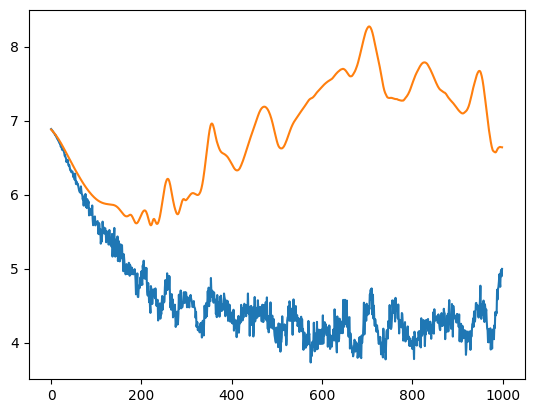

In [124]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":10, "num_heads" : 2,
          "n_encoder":1, "n_decoder":1,
          "dropout_p":0,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model_increase_heads= Transformer(**config)
model_increase_heads.apply(_init_weights)
# check model parameter
print('#parameters :', sum([p.numel() for p in model_increase_heads.parameters()]))

for p in model_increase_heads.parameters() :
  p.require_grad = True


optimizer = torch.optim.Adam(model_increase_heads.parameters())

losses = []
losses_val = []
max_iter = 1_000
for iter in range(max_iter):
    t1 = time.time()

    # Minibatch Samples
    X_minibatch,y_minibatch = get_batches(split='train',batch_size=BATCH_SIZE)
    y_input_minibatch = y_minibatch[:,:-1]
    y_label_minibatch = y_minibatch[:,1:]

    # Forward pass
    logit = model_increase_heads(X_minibatch,y_input_minibatch)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=config['tgt_padding_idx'])

    # Backward pass
    for p in model_increase_depth.parameters():
        p.grad = None

    loss.backward()

    optimizer.step()
    loss_val = evaluate_loss(split='valid',model=model_increase_heads,device=config['device'])
    # Append the loss
    losses.append(loss.item())
    losses_val.append(loss_val.item())
    elapsed = time.time() - t1
    if iter % 100 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss {loss.item():.4f} "
              f"| Loss on Validation {loss_val.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")

# plot the loss
iter = [x for x in range(len(losses))]
plt.plot(iter,losses)
plt.plot(iter,losses_val)


#### Checking Initial Loss

In [125]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":10, "num_heads" : 1,
          "n_encoder":1, "n_decoder":1,
          "dropout_p":0.1,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model = Transformer(**config)

# check model parameter
print('#parameters :', sum([p.numel() for p in model.parameters()]))

for p in model.parameters() :
  p.require_grad = True

#parameters : 43612


In [126]:
optimizer = torch.optim.Adam(model.parameters())


In [127]:
losses = []
max_iter = 5_000
for iter in range(max_iter):
    t1 = time.time()

    # Minibatch Samples
    X_minibatch,y_minibatch = get_batches(split='train',batch_size=BATCH_SIZE)
    y_input_minibatch = y_minibatch[:,:-1]
    y_label_minibatch = y_minibatch[:,1:]

    # Forward pass
    logit = model(X_minibatch,y_input_minibatch)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=config['tgt_padding_idx'])

    # Backward pass
    for p in model.parameters():
        p.grad = None

    loss.backward()

    optimizer.step()

    # Append the loss
    losses.append(loss.item())
    elapsed = time.time() - t1
    if iter % 100 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss {loss.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")
    break


Step       0/   5000 | Loss 7.0215 | Step time 12.57 ms


Ideal Loss at the beginning should be $-log(\cfrac{1}{\text{vocab-target}})$

In [128]:
-np.log(1/len(idn_vocab))

6.883462586413092

Our Loss bit bit higher

Now, we will also log the error on validation and training data

In [129]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":10, "num_heads" : 1,
          "n_encoder":1, "n_decoder":1,
          "dropout_p":0.1,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model = Transformer(**config)

# check model parameter
print('#parameters :', sum([p.numel() for p in model.parameters()]))

for p in model.parameters() :
  p.require_grad = True

#parameters : 43612


In [130]:
optimizer = torch.optim.Adam(model.parameters())


In [132]:
losses = []
losses_train = []
losses_val = []
max_iter = 1_000
for iter in range(max_iter):
    t1 = time.time()

    # Minibatch Samples
    X_minibatch,y_minibatch = get_batches(split='train',batch_size=BATCH_SIZE)
    y_input_minibatch = y_minibatch[:,:-1]
    y_label_minibatch = y_minibatch[:,1:]

    # Forward pass
    logit = model(X_minibatch,y_input_minibatch)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=TGT_PAD_IDX)

    # Backward pass
    for p in model.parameters():
        p.grad = None

    loss.backward()

    optimizer.step()
    # calculate loss
    loss_train = evaluate_loss(split='train',model=model,device=config['device'])
    loss_val = evaluate_loss(split='valid',model=model,device=config['device'])

    # Append the loss
    losses.append(loss.item())
    losses_train.append(loss_train.item())
    losses_val.append(loss_val.item())
    elapsed = time.time() - t1
    if iter % 20 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss on Minibatch {loss.item():.4f} "
              f"| Loss on Training Set {loss_train.item():.4f} "
              f"| Loss on Val Set  {loss_val.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")


Step       0/   1000 | Loss on Minibatch 6.9269 | Loss on Training Set 6.9294 | Loss on Val Set  6.9208 | Step time 50.95 ms
Step      20/   1000 | Loss on Minibatch 6.6270 | Loss on Training Set 6.6790 | Loss on Val Set  6.7286 | Step time 47.19 ms
Step      40/   1000 | Loss on Minibatch 6.5016 | Loss on Training Set 6.4403 | Loss on Val Set  6.5319 | Step time 47.40 ms
Step      60/   1000 | Loss on Minibatch 6.2468 | Loss on Training Set 6.2216 | Loss on Val Set  6.3478 | Step time 46.88 ms
Step      80/   1000 | Loss on Minibatch 5.9678 | Loss on Training Set 6.0058 | Loss on Val Set  6.2023 | Step time 47.28 ms
Step     100/   1000 | Loss on Minibatch 5.7940 | Loss on Training Set 5.8026 | Loss on Val Set  6.0439 | Step time 46.79 ms
Step     120/   1000 | Loss on Minibatch 5.6386 | Loss on Training Set 5.6309 | Loss on Val Set  5.9302 | Step time 46.91 ms
Step     140/   1000 | Loss on Minibatch 5.4437 | Loss on Training Set 5.4876 | Loss on Val Set  5.8306 | Step time 47.17 ms


#### Overfit on Small Batch

To check model capabilities, if the model learn it can overfit small amount of training sample

In [133]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":10, "num_heads" : 1,
          "n_encoder":1, "n_decoder":1,
          "dropout_p":0.1,
          "device" : 'cuda' if torch.cuda.is_available==True else 'cpu' ,
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
model = Transformer(**config).to(config['device'])

# check model parameter
print('#parameters :', sum([p.numel() for p in model.parameters()]))

for p in model.parameters() :
  p.require_grad = True

#parameters : 43612


In [134]:
optimizer = torch.optim.Adam(model.parameters())



In [135]:
X_minibatch,y_minibatch = get_batches(split='train',batch_size=20)
y_input_minibatch = y_minibatch[:,:-1].to(config['device'])
y_label_minibatch = y_minibatch[:,1:].to(config['device'])

In [136]:
losses = []
max_iter = 5_00
for iter in range(max_iter):
    t1 = time.time()


    # Forward pass
    logit = model(X_minibatch,y_input_minibatch)

    B,T,VOCAB = logit.shape

    logit_ = logit.reshape(shape=(B*T,VOCAB))
    y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
    loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=TGT_PAD_IDX)

    # Backward pass
    for p in model.parameters():
        p.grad = None

    loss.backward()

    optimizer.step()

    # Append the loss
    losses.append(loss.item())
    elapsed = time.time() - t1
    if iter % 100 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss {loss.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")



Step       0/    500 | Loss 7.2476 | Step time 13.60 ms
Step     100/    500 | Loss 5.2796 | Step time 10.72 ms
Step     200/    500 | Loss 3.9948 | Step time 8.61 ms
Step     300/    500 | Loss 3.1238 | Step time 8.79 ms
Step     400/    500 | Loss 2.4312 | Step time 8.76 ms


We see that our loss can reach minimum , which is near zero, okay we are good then!

### Retrain the model

but before that we should create training function

In [137]:
# We create the training function
def train(model,
          batch_size,
          max_iter,
          optimizer,device,
          clip,
          logging_interim = 100
          ):
    # Initialize
    losses = []
    losses_train = []
    losses_val = []
    decay_flag = False
    best_valid_loss = float('inf')
    # Iterate
    for iter in range(max_iter):
        t1 = time.time()

        # Construct the minibatch
        X_minibatch,y_minibatch = get_batches(split='train',batch_size=batch_size)
        X_minibatch = X_minibatch.to(device)
        y_input_minibatch = y_minibatch[:,:-1].to(device)
        y_label_minibatch = y_minibatch[:,1:].to(device)


        # Forward pass
        logit = model(X_minibatch,y_input_minibatch)

        B,T,VOCAB = logit.shape

        logit_ = logit.reshape(shape=(B*T,VOCAB))
        y_label_minibatch_ = y_label_minibatch.reshape(shape=(B*T,))
        loss = F.cross_entropy(logit_, y_label_minibatch_,ignore_index=TGT_PAD_IDX)

        # Backward pass
        for p in model.parameters():
            p.grad = None

        loss.backward()
        # calculate loss
        #loss_train = evaluate_loss(split='train',model=model,device=device)
        loss_val = evaluate_loss(split='valid',model=model,device=device)

        # Append the loss
        losses.append(loss.item())
        # losses_train.append(loss_train.item())
        losses_val.append(loss_val.item())
        # Update the parameters
        # Custom decay
        optimizer.step()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Append the loss
        elapsed = time.time() - t1
        if max_iter == 1:
            print(f"Step {iter:7d}/{max_iter:7d} "
                f"| Loss {loss.item():.4f} "
                f"| Step time {elapsed*1000:.2f} ms")

        elif iter % logging_interim == 0:
          print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss mini batch {loss.item():.4f} "
              f"| Loss valid {loss_val.item():.4f} "

              f"| Step time {elapsed*1000:.2f} ms")

        # if validation loss goes down --> save model
        if loss_val.item() < best_valid_loss :
            best_valid_loss = loss_val.item()
            torch.save({
              'iter': iter,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_loss': loss_val
              }, 'model_check/best_model.pt')

    return losses,losses_val


In [141]:
config

{'tgt_vocab_num': 976,
 'src_vocab_num': 935,
 'n_dim': 20,
 'num_heads': 2,
 'n_encoder': 1,
 'n_decoder': 2,
 'dropout_p': 0.1,
 'device': 'cuda',
 'sequence_length_encoder': 14,
 'sequence_length_decoder': 13,
 'src_padding_idx': 183,
 'tgt_padding_idx': 165}

In [142]:
BATCH_SIZE = 32
config = {"tgt_vocab_num":len(idn_vocab),
          "src_vocab_num":len(eng_vocab),
          "n_dim":20, "num_heads" : 2,
          "n_encoder":1, "n_decoder":2,
          "dropout_p":0.1,
          "device" : 'cpu',
          "sequence_length_encoder":ENCODER_SEQUENCE_LENGTH,
          "sequence_length_decoder":DECODER_SEQUENCE_LENGTH,
          "src_padding_idx":word_to_idx_src['<PAD>'],
          "tgt_padding_idx":word_to_idx_tgt['<PAD>']
}
device = 'cuda' if torch.cuda.is_available()== True else 'cpu'

model_retrain = Transformer(**config).to(device)
model_retrain.apply(_init_weights)
# check model parameter
print('#parameters :', sum([p.numel() for p in model_retrain.parameters()]))

for p in model_retrain.parameters() :
  p.require_grad = True


# Next, define optimizer
optimizer = torch.optim.Adam(model_retrain.parameters(),lr=5e-4,weight_decay=0.01)

#parameters : 97532


In [ ]:
# !mkdir model_check

mkdir: cannot create directory ‘model_check’: File exists


In [144]:
losses,losses_val = train(model=model_retrain,
          batch_size=64,
          max_iter=2000,clip=1,
          optimizer=optimizer,device='cpu')

Step       0/   2000 | Loss mini batch 6.8830 | Loss valid 6.8839 | Step time 46.60 ms
Step     100/   2000 | Loss mini batch 6.0429 | Loss valid 6.2426 | Step time 37.90 ms
Step     200/   2000 | Loss mini batch 5.6015 | Loss valid 5.8113 | Step time 36.27 ms
Step     300/   2000 | Loss mini batch 5.2588 | Loss valid 5.6179 | Step time 36.41 ms
Step     400/   2000 | Loss mini batch 5.1718 | Loss valid 5.4826 | Step time 36.29 ms
Step     500/   2000 | Loss mini batch 4.9361 | Loss valid 5.3339 | Step time 35.30 ms
Step     600/   2000 | Loss mini batch 4.8238 | Loss valid 5.2029 | Step time 35.95 ms
Step     700/   2000 | Loss mini batch 4.7058 | Loss valid 5.1343 | Step time 35.28 ms
Step     800/   2000 | Loss mini batch 4.6785 | Loss valid 5.1106 | Step time 35.32 ms
Step     900/   2000 | Loss mini batch 4.5872 | Loss valid 5.1213 | Step time 34.64 ms
Step    1000/   2000 | Loss mini batch 4.5700 | Loss valid 5.1024 | Step time 35.84 ms
Step    1100/   2000 | Loss mini batch 4.54

Let's save our model first

In [145]:
transformer_model = Transformer(**config).to(config['device'])


checkpoint = torch.load('model_check/best_model.pt')
transformer_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [146]:
val_loss = checkpoint['val_loss']
val_loss

tensor(5.0398, dtype=torch.float64)

In [148]:
evaluate_loss(split='test',model=transformer_model,device='cpu')


tensor(5.6663, dtype=torch.float64)

In [150]:
evaluate_loss(split='valid',model=transformer_model,device='cpu')


tensor(5.1390, dtype=torch.float64)

In [152]:
evaluate_loss(split='train',model=transformer_model,device='cpu')

tensor(4.3915, dtype=torch.float64)

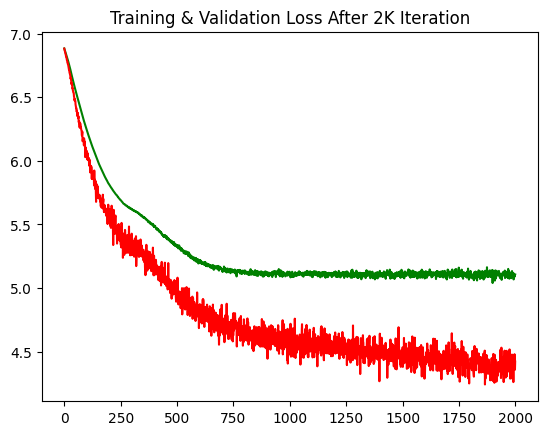

In [153]:

plt.title('Training & Validation Loss After 2K Iteration')
plt.plot([x for x in range(len(losses_val))],losses_val,color='g')
plt.plot([x for x in range(len(losses))],losses,color='r')

## Let's Generate Some Translation

Let's use some word on test data

In [154]:
X_test_sample,y_test_sample = get_batches(split='test',batch_size=1)

In [156]:
X_test_sample = X_test_sample.to('cpu')
y_test_sample = y_test_sample.to('cpu')

In [157]:
y_test_sample

tensor([[285, 778, 802, 457, 512, 778, 872, 953,  91, 426, 165, 165, 165,   0]])

To generate translation, we can run in `no gradient` mode or inference mode

In [158]:
X_,y_ = get_batches(split='test',batch_size=1)

In [159]:
X_ = X_.to(config['device'])
y_ = y_.to(config['device'])

In [160]:
tokens = torch.LongTensor([y_[:,0].item()]).unsqueeze(0)
tokens.shape

torch.Size([1, 1])

In [161]:
#
EOS_TGT_IDX = word_to_idx_tgt['<PAD>']

encoder_rep = transformer_model.encoder(X_)
tokens = torch.LongTensor([y_[:,0].item()]).unsqueeze(0).to(config['device'])
while True :
  try :
    # prepare token
    input = tokens if tokens.size(1) <= config['sequence_length_decoder'] else tokens[:,-config['sequence_length_decoder']:]
    before_projection = transformer_model.decoder(y=input,encoder_output=encoder_rep)
    logit = transformer_model.final_projection(before_projection)
    idx_logit = tokens.size(1)
    logit = logit[:,idx_logit-1,:]
    #

    #print('LOGIT SHAPE',logit.shape)
    # get current position + 1

    # select only current step

    probs = torch.nn.functional.softmax(logit,dim=-1)

      # next idx
    next_idx = torch.topk(probs,k=1).indices
    # cat with tokens
    tokens = torch.cat([tokens,next_idx],dim=-1)
  except :

    print('Generation is Done !')
    break



Generation is Done !


In [162]:
@torch.no_grad()
def generate_translation(model,EOS_TGT_IDX,inputs,device,config,word_to_idx_tgt) :
      EOS_TGT_IDX = word_to_idx_tgt['<PAD>']

      encoder_rep = model.encoder(inputs)
      tokens = torch.LongTensor([word_to_idx_tgt['<START>']]).unsqueeze(0).to(config['device'])
      while True :
        try :
          # prepare token
          input = tokens if tokens.size(1) <= config['sequence_length_decoder'] else tokens[:,-config['sequence_length_decoder']:]
          before_projection = model.decoder(y=input,encoder_output=encoder_rep)
          logit = transformer_model.final_projection(before_projection)
          idx_logit = tokens.size(1)
          logit = logit[:,idx_logit-1,:]
          #

          print('LOGIT SHAPE',logit.shape)
          # get current position + 1

          # select only current step

          probs = torch.nn.functional.softmax(logit,dim=-1)

            # next idx
          next_idx = torch.topk(probs,k=1).indices
          # cat with tokens
          tokens = torch.cat([tokens,next_idx],dim=-1)
        except :
          print('Generation is Done!')
          break


      return tokens

In [163]:
words_collected = []
for tok in X_.view(-1) :
  # print word
  words_collected.append(idx_to_word_src[tok.item()])
' '.join(words_collected)

' she came to japan for the purpose of studying japanese  <PAD> '

In [164]:
words_collected = []
for tok in y_.view(-1) :
  # print word
  words_collected.append(idx_to_word_tgt[tok.item()])
' '.join(words_collected)

'<SOS> dia datang ke jepang untuk belajar bahasa jepang <EOS> <PAD> <PAD> <PAD> untukmu'

In [165]:
words_collected = []
for tok in tokens.view(-1) :
  # print word
  words_collected.append(idx_to_word_tgt[tok.item()])
' '.join(words_collected)

'<SOS> aku tidak tidak tahu tom yang tidak tidak tidak <EOS> <EOS> untukmu untukmu'

Not Quite Accurate Translation